**This code is base on [2.5d segmentaion baseline [inference]](https://www.kaggle.com/code/tanakar/2-5d-segmentaion-baseline-inference)**
If you think my code is useful,please upvote it ^w^.
* Version2:
1. *     updata normalization method
2. *     image_size = 512
3. *     useing 3d TTA
4. *     se_resnext50_32x4d

* Version3:
1. *     updata normalization method

* This version is correspond with [2.5d segmentaion baseline [training]](https://www.kaggle.com/code/yoyobar/2-5d-cutting-model-baseline-training) version6


# Import

In [15]:
import torch as tc 
import torch.nn as nn  
import numpy as np
import itertools
from tqdm import tqdm
from torch.cuda.amp import autocast
import cv2
import os,sys
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd
!python -m pip install --no-index --find-links=/kaggle/input/pip-download-for-segmentation-models-pytorch segmentation-models-pytorch
import segmentation_models_pytorch as smp
from torch.utils.data import Dataset, DataLoader
from torch.nn.parallel import DataParallel
from dotenv import load_dotenv


Looking in links: /kaggle/input/pip-download-for-segmentation-models-pytorch


# config

In [16]:
class CFG:
# ============== model CFG =============
    model_name = 'Unet'
    backbone = 'se_resnext50_32x4d'

    in_chans = 5 # 65
    #============== _ CFG =============
    image_size = 512
    input_size=512
    tile_size = image_size
    stride = tile_size // 4
    drop_egde_pixel=32
    
    target_size = 1
    chopping_percentile=1e-3
    # ============== fold =============
    valid_id = 1
    batch=128
    th_percentile = 0.0021
    model_path=["/kaggle/input/2-5d-cutting-model-baseline-training/se_resnext50_32x4d_19_loss0.12_score0.79_val_loss0.25_val_score0.79.pt"]


# Model

In [17]:
class CustomModel(nn.Module):
    def __init__(self, CFG, weight=None):
        super().__init__()
        self.CFG = CFG
        self.model = smp.Unet(
            encoder_name=CFG.backbone, 
            encoder_weights=weight,
            in_channels=CFG.in_chans,
            classes=CFG.target_size,
            activation=None,
        )
        self.batch=CFG.batch

    def forward_(self, image):
        output = self.model(image)
        return output[:,0]
    
    def forward(self,x:tc.Tensor):
        #x.shape=(batch,c,h,w)
        x=x.to(tc.float32)
        x=norm_with_clip(x.reshape(-1,*x.shape[2:])).reshape(x.shape)
        
        if CFG.input_size!=CFG.image_size:
            x=nn.functional.interpolate(x,size=(CFG.input_size,CFG.input_size),mode='bilinear',align_corners=True)
        
        shape=x.shape
        x=[tc.rot90(x,k=i,dims=(-2,-1)) for i in range(4)]
        x=tc.cat(x,dim=0)
        with autocast():
            with tc.no_grad():
                x=[self.forward_(x[i*self.batch:(i+1)*self.batch]) for i in range(x.shape[0]//self.batch+1)]
                # batch=64,64...48
                x=tc.cat(x,dim=0)
        x=x.sigmoid()
        x=x.reshape(4,shape[0],*shape[2:])
        x=[tc.rot90(x[i],k=-i,dims=(-2,-1)) for i in range(4)]
        x=tc.stack(x,dim=0).mean(0)
        
        if CFG.input_size!=CFG.image_size:
            x=nn.functional.interpolate(x[None],size=(CFG.image_size,CFG.image_size),mode='bilinear',align_corners=True)[0]
        return x


def build_model(weight=None):
    load_dotenv()

    print('model_name', CFG.model_name)
    print('backbone', CFG.backbone)

    model = CustomModel(CFG, weight)

    return model.cuda()

# Functions

In [18]:
def rle_encode(mask):
    pixel = mask.flatten()
    pixel = np.concatenate([[0], pixel, [0]])
    run = np.where(pixel[1:] != pixel[:-1])[0] + 1
    run[1::2] -= run[::2]
    rle = ' '.join(str(r) for r in run)
    if rle == '':
        rle = '1 0'
    return rle

def min_max_normalization(x:tc.Tensor)->tc.Tensor:
    """input.shape=(batch,f1,...)"""
    shape=x.shape
    if x.ndim>2:
        x=x.reshape(x.shape[0],-1)
    
    min_=x.min(dim=-1,keepdim=True)[0]
    max_=x.max(dim=-1,keepdim=True)[0]
    if min_.mean()==0 and max_.mean()==1:
        return x.reshape(shape)
    
    x=(x-min_)/(max_-min_+1e-9)
    return x.reshape(shape)

def norm_with_clip(x:tc.Tensor,smooth=1e-5):
    dim=list(range(1,x.ndim))
    mean=x.mean(dim=dim,keepdim=True)
    std=x.std(dim=dim,keepdim=True)
    x=(x-mean)/(std+smooth)
    x[x>5]=(x[x>5]-5)*1e-3 +5
    x[x<-3]=(x[x<-3]+3)*1e-3-3
    return x

class Data_loader(Dataset):
    def __init__(self,path,s="/images/"):
        self.paths=glob(path+f"{s}*.tif")
        self.paths.sort()
        self.bool=s=="/labels/"
    
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self,index):
        img=cv2.imread(self.paths[index],cv2.IMREAD_GRAYSCALE)
        img=tc.from_numpy(img)
        if self.bool:
            img=img.to(tc.bool)
        else:
            img=img.to(tc.uint8)
        return img

def load_data(path,s):
    data_loader=Data_loader(path,s)
    data_loader=DataLoader(data_loader, batch_size=16, num_workers=2)
    data=[]
    for x in tqdm(data_loader):
        data.append(x)
    x=tc.cat(data,dim=0)
    ########################################################################
    TH=x.reshape(-1).numpy()
    index = -int(len(TH) * CFG.chopping_percentile)
    TH:int = np.partition(TH, index)[index]
    x[x>TH]=int(TH)
    ########################################################################
    TH=x.reshape(-1).numpy()
    index = -int(len(TH) * CFG.chopping_percentile)
    TH:int = np.partition(TH, -index)[-index]
    x[x<TH]=int(TH)
    ########################################################################
    #x=(min_max_normalization(x.to(tc.float16))*255).to(tc.uint8)
    return x

class Pipeline_Dataset(Dataset):
    def __init__(self,x,path):
        self.img_paths  = glob(path+"/images/*")
        self.img_paths.sort()
        self.in_chan = CFG.in_chans
        z=tc.zeros(self.in_chan//2,*x.shape[1:],dtype=x.dtype)
        self.x=tc.cat((z,x,z),dim=0)
        
    def __len__(self):
        return self.x.shape[0]-self.in_chan+1
    
    def __getitem__(self, index):
        x  = self.x[index:index+self.in_chan]
        return x,index
    
    def get_mark(self,index):
        id=self.img_paths[index].split("/")[-3:]
        id.pop(1)
        id="_".join(id)
        return id[:-4]
    
    def get_marks(self):
        ids=[]
        for index in range(len(self)):
            ids.append(self.get_mark(index))
        return ids

def add_edge(x:tc.Tensor,edge:int):
    #x=(C,H,W)
    #output=(C,H+2*edge,W+2*edge)
    mean_=int(x.to(tc.float32).mean())
    x=tc.cat([x,tc.ones([x.shape[0],edge,x.shape[2]],dtype=x.dtype,device=x.device)*mean_],dim=1)
    x=tc.cat([x,tc.ones([x.shape[0],x.shape[1],edge],dtype=x.dtype,device=x.device)*mean_],dim=2)
    x=tc.cat([tc.ones([x.shape[0],edge,x.shape[2]],dtype=x.dtype,device=x.device)*mean_,x],dim=1)
    x=tc.cat([tc.ones([x.shape[0],x.shape[1],edge],dtype=x.dtype,device=x.device)*mean_,x],dim=2)
    return x

# Build model(s)

In [19]:
model=build_model()
model.load_state_dict(tc.load(CFG.model_path[0],"cpu"))
model.eval()
model=DataParallel(model)

model_name Unet
backbone se_resnext50_32x4d


In [20]:

def get_output(debug=False):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Remove grid background
    ax.grid(False)

    # Set background color to white
    ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

    # Set axis labels color to black
    ax.xaxis.label.set_color('black')
    ax.yaxis.label.set_color('black')
    ax.zaxis.label.set_color('black')

    # Set tick labels color to black
    ax.tick_params(axis='x', colors='black')
    ax.tick_params(axis='y', colors='black')
    ax.tick_params(axis='z', colors='black')

    outputs=[]
    if debug:
        paths=["/kaggle/input/blood-vessel-segmentation/train/kidney_1_dense"]
    else:
        paths=glob("/kaggle/input/blood-vessel-segmentation/test/*")
    outputs=[[],[]]
    for path in paths:
        x=load_data(path,"/images/")
        labels=tc.zeros_like(x,dtype=tc.uint8)
        mark=Pipeline_Dataset(x,path).get_marks()
        for axis in [0]:
            debug_count=0
            if axis==0:
                x_=x
                labels_=labels
            elif axis==1:
                x_=x.permute(1,2,0)
                labels_=labels.permute(1,2,0)
            elif axis==2:
                x_=x.permute(2,0,1)
                labels_=labels.permute(2,0,1)
            if x.shape[0]==3 and axis!=0:
                break
            dataset=Pipeline_Dataset(x_,path)
            dataloader=DataLoader(dataset,batch_size=1,shuffle=False,num_workers=2)
            shape=dataset.x.shape[-2:]
            x1_list = np.arange(0, shape[0]+CFG.tile_size-CFG.tile_size+1, CFG.stride)
            y1_list = np.arange(0, shape[1]+CFG.tile_size-CFG.tile_size+1, CFG.stride)
            i2 = 699
            for img, index in itertools.islice(dataloader, 699, None):
                i2+=1
                #img=(1,C,H,W)
                img=img.to("cuda:0")
                img=add_edge(img[0],CFG.tile_size//2)[None]

                mask_pred = tc.zeros_like(img[:,0],dtype=tc.float32,device=img.device)
                mask_count = tc.zeros_like(img[:,0],dtype=tc.float32,device=img.device)

                indexs=[]
                chip=[]
                for y1 in y1_list:
                    for x1 in x1_list:
                        x2 = x1 + CFG.tile_size
                        y2 = y1 + CFG.tile_size
                        indexs.append([x1+CFG.drop_egde_pixel,x2-CFG.drop_egde_pixel,
                                       y1+CFG.drop_egde_pixel,y2-CFG.drop_egde_pixel])
                        chip.append(img[...,x1:x2,y1:y2])

                y_preds = model.forward(tc.cat(chip)).to(device=0)

                if CFG.drop_egde_pixel:
                    y_preds=y_preds[...,CFG.drop_egde_pixel:-CFG.drop_egde_pixel,
                                        CFG.drop_egde_pixel:-CFG.drop_egde_pixel]
                for i,(x1,x2,y1,y2) in enumerate(indexs):
                    mask_pred[...,x1:x2, y1:y2] += y_preds[i]
                    mask_count[...,x1:x2, y1:y2] += 1
 
                mask_pred /= mask_count

                #Rrecover
                mask_pred=mask_pred[...,CFG.tile_size//2:-CFG.tile_size//2,CFG.tile_size//2:-CFG.tile_size//2]
                
                labels_[index]+=(mask_pred[0]*255/3).to(tc.uint8).cpu()
                print(x2)
                non_zero_coords = mask_pred[0].nonzero()
                # Check if there are non-zero values before attempting to unpack
                
                if non_zero_coords.dim() == 2:
                    x, y = non_zero_coords.unbind(1)
                    z = tc.full_like(x, fill_value=i2)  # Use the image index as the z-coordinate
                elif non_zero_coords.dim() == 1:
                    x, y = non_zero_coords.unbind(0)
                    z = tc.full_like(x, fill_value=i2)  # Use the image index as the z-coordinate
                else:
                    x, y, z = non_zero_coords.unbind(1)

                # Scatter plot with blue color, marker size, and transparency
                print(x.cpu())
                ax.scatter(x.cpu(), y.cpu(), z.cpu(), c='blue', marker='o', s=2, alpha=0.5)
                
                if debug:
                    debug_count+=1
                    #plt.subplot(121)
                    #plt.imshow(img[0,CFG.in_chans//2].cpu().detach().numpy())
                    #plt.subplot(122)
                    print(type(mask_pred[0]))
                    #plt.imshow(mask_pred[0].cpu().detach().numpy())
                    print((mask_pred[0][0][0].cpu()))
                    
                    if debug_count>5:
                        break
                    ax.set_xlabel('X')
                    ax.set_ylabel('Y')
                    ax.set_zlabel('Z')
                    ax.set_title('Combined 3D Segmentation Result for All Images')

                    
        outputs[0].append(labels)
        outputs[1].extend(mark)
        plt.show()
    return outputs

/tmp/ipykernel_47/996427358.py:9: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
/tmp/ipykernel_47/996427358.py:10: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use yaxis instead.
  ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
/tmp/ipykernel_47/996427358.py:11: MatplotlibDeprecationWarning: The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.
  ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
100%|██████████| 143/143 [00:06<00:00, 23.08it/s]


1760
tensor([   0,    0,    0,  ..., 1302, 1302, 1302])
<class 'torch.Tensor'>
tensor(8.1316e-05)
1760
tensor([   0,    0,    0,  ..., 1302, 1302, 1302])
<class 'torch.Tensor'>
tensor(8.0764e-05)
1760
tensor([   0,    0,    0,  ..., 1302, 1302, 1302])
<class 'torch.Tensor'>
tensor(8.0153e-05)
1760
tensor([   0,    0,    0,  ..., 1302, 1302, 1302])
<class 'torch.Tensor'>
tensor(8.0511e-05)
1760
tensor([   0,    0,    0,  ..., 1302, 1302, 1302])
<class 'torch.Tensor'>
tensor(8.0347e-05)
1760
tensor([   0,    0,    0,  ..., 1302, 1302, 1302])
<class 'torch.Tensor'>
tensor(8.0824e-05)


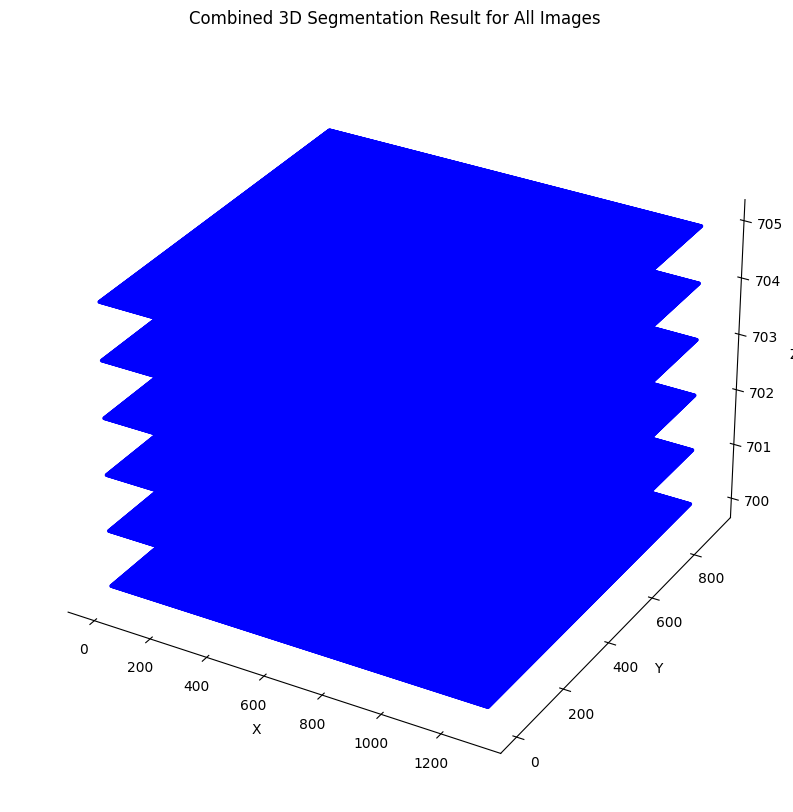

In [21]:
is_submit=len(glob("/kaggle/input/blood-vessel-segmentation/test/kidney_5/images/*.tif"))!=3
#is_submit=True
output,ids=get_output(not is_submit)

